In [1]:
!pip install -q \
    numpy \
    scipy \
    scikit-learn \
    matplotlib \
    psutil \
    onnxruntime \
    faiss-cpu \
    sentence-transformers \
    llama-cpp-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.5 MB/s eta 0:00:00


In [52]:
import os, time, psutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import onnxruntime as ort
import faiss
from sklearn.metrics.pairwise import cosine_similarity

random.seed(42)
np.random.seed(42)
torch.set_num_threads(2)


In [53]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""
assert not torch.cuda.is_available()
print("CPU-only execution confirmed")


CPU-only execution confirmed


In [54]:
# Official baseline (FP32, PyTorch)
BASE_MODEL = "BAAI/bge-small-en-v1.5"

bge_fp32 = SentenceTransformer(BASE_MODEL)
print("Loaded baseline:", BASE_MODEL)


Loaded baseline: BAAI/bge-small-en-v1.5


In [56]:
BGE_ONNX_DIR = "/content/bge"

tokenizer = AutoTokenizer.from_pretrained(BGE_ONNX_DIR)

bge_onnx = ort.InferenceSession(
    os.path.join(BGE_ONNX_DIR, "model_quantized.onnx"),
    providers=["CPUExecutionProvider"]
)


In [57]:
def embed_onnx(texts, dim=128):
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="np"
    )
    out = bge_onnx.run(
        None,
        {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "token_type_ids": enc.get(
                "token_type_ids",
                np.zeros_like(enc["input_ids"])
            )
        }
    )[0]
    return out[:, :dim]


In [58]:
from huggingface_hub import snapshot_download

def folder_size_mb(path):
    return sum(
        os.path.getsize(os.path.join(r,f))
        for r,_,fs in os.walk(path) for f in fs
    ) / 1024**2

baseline_path = snapshot_download(BASE_MODEL)
disk_fp32 = folder_size_mb(baseline_path)
disk_onnx = folder_size_mb(BGE_ONNX_DIR)

disk_fp32, disk_onnx


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

onnx/model.onnx:   0%|          | 0.00/133M [00:00<?, ?B/s]

(382.527681350708, 33.32806968688965)

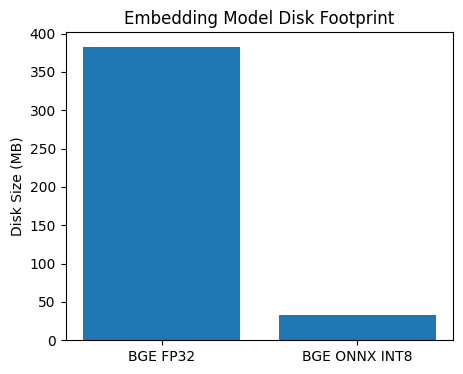

In [59]:
plt.figure(figsize=(5,4))
plt.bar(["BGE FP32", "BGE ONNX INT8"], [disk_fp32, disk_onnx])
plt.ylabel("Disk Size (MB)")
plt.title("Embedding Model Disk Footprint")
plt.show()


In [69]:
def latency(fn, texts, runs=5):
    times = []
    for _ in range(runs):
        t0 = time.time()
        fn(texts)
        times.append(time.time() - t0)
    return np.mean(times)


In [70]:
batch_sizes = [1, 4, 8, 16]
lat_fp32, lat_onnx = [], []

for b in batch_sizes:
    texts = ["Latency test sentence"] * b
    lat_fp32.append(latency(bge_fp32.encode, texts))
    lat_onnx.append(latency(embed_onnx, texts))

lat_fp32, lat_onnx


([np.float64(0.47669677734375),
  np.float64(0.26671633720397947),
  np.float64(0.1758218765258789),
  np.float64(0.27347517013549805)],
 [np.float64(0.021437788009643556),
  np.float64(0.029776668548583983),
  np.float64(0.03330140113830567),
  np.float64(0.10418000221252441)])

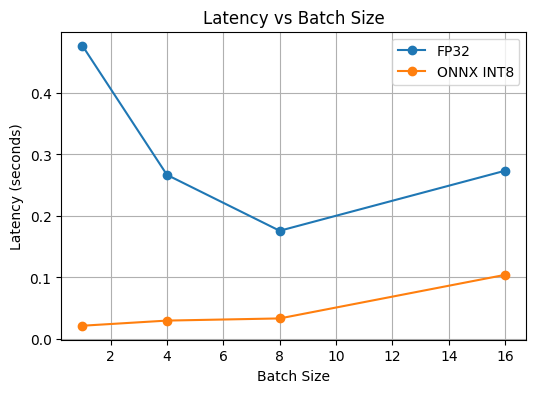

In [71]:
plt.figure(figsize=(6,4))
plt.plot(batch_sizes, lat_fp32, marker="o", label="FP32")
plt.plot(batch_sizes, lat_onnx, marker="o", label="ONNX INT8")
plt.xlabel("Batch Size")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs Batch Size")
plt.legend()
plt.grid(True)
plt.show()


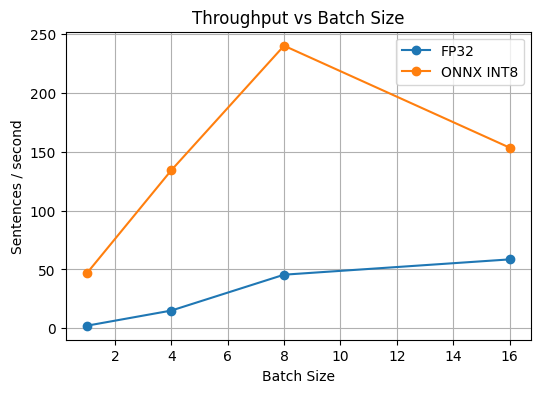

In [72]:
tp_fp32 = [b/t for b,t in zip(batch_sizes, lat_fp32)]
tp_onnx = [b/t for b,t in zip(batch_sizes, lat_onnx)]

plt.figure(figsize=(6,4))
plt.plot(batch_sizes, tp_fp32, marker="o", label="FP32")
plt.plot(batch_sizes, tp_onnx, marker="o", label="ONNX INT8")
plt.xlabel("Batch Size")
plt.ylabel("Sentences / second")
plt.title("Throughput vs Batch Size")
plt.legend()
plt.grid(True)
plt.show()


In [73]:
similar = [
    ("AI improves healthcare", "Artificial intelligence enhances medicine"),
    ("Cats are mammals", "Dogs are mammals"),
]*5

dissimilar = [
    ("AI improves healthcare", "Bananas are yellow"),
    ("Cats are mammals", "Quantum field theory"),
]*5


In [80]:
def embed_onnx(texts, dim=128):
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="np"
    )

    # ONNX forward → token embeddings (B, T, H)
    token_embeddings = bge_onnx.run(
        None,
        {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "token_type_ids": enc.get(
                "token_type_ids",
                np.zeros_like(enc["input_ids"])
            )
        }
    )[0].astype(np.float32)

    # Mean pooling (mask-aware)
    mask = enc["attention_mask"][..., None].astype(np.float32)
    summed = (token_embeddings * mask).sum(axis=1)
    counts = np.clip(mask.sum(axis=1), 1e-9, None)
    sentence_embeddings = summed / counts

    # Matryoshka truncation (LAST DIMENSION)
    sentence_embeddings = sentence_embeddings[:, :dim]

    # L2 normalization (float32-safe)
    norms = np.linalg.norm(sentence_embeddings, axis=1, keepdims=True)
    sentence_embeddings = sentence_embeddings / np.clip(norms, 1e-9, None)

    # 🚨 CRITICAL: enforce float32 for FAISS
    return sentence_embeddings.astype(np.float32)


In [81]:
recall_fp32 = recall_at_k(bge_fp32.encode, 3)
recall_onnx = recall_at_k(embed_onnx, 3)

recall_fp32, recall_onnx



(1.0, 1.0)

In [84]:
def similarities(pairs, fn):
    scores = []
    for a,b in pairs:
        e = fn([a,b])
        scores.append(cosine_similarity([e[0]],[e[1]])[0][0])
    return scores

sim_fp32 = similarities(similar, bge_fp32.encode)
sim_onnx = similarities(similar, embed_onnx)

dis_fp32 = similarities(dissimilar, bge_fp32.encode)
dis_onnx = similarities(dissimilar, embed_onnx)


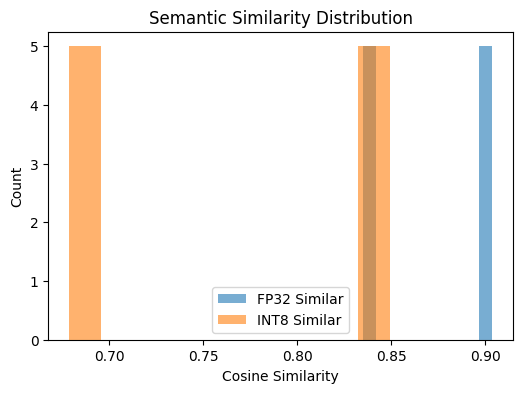

In [85]:
plt.figure(figsize=(6,4))
plt.hist(sim_fp32, bins=10, alpha=0.6, label="FP32 Similar")
plt.hist(sim_onnx, bins=10, alpha=0.6, label="INT8 Similar")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.title("Semantic Similarity Distribution")
plt.legend()
plt.show()


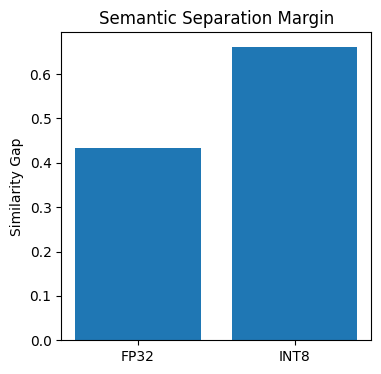

In [86]:
gap_fp32 = np.mean(sim_fp32) - np.mean(dis_fp32)
gap_onnx = np.mean(sim_onnx) - np.mean(dis_onnx)

plt.figure(figsize=(4,4))
plt.bar(["FP32", "INT8"], [gap_fp32, gap_onnx])
plt.ylabel("Similarity Gap")
plt.title("Semantic Separation Margin")
plt.show()


In [87]:
corpus = [
    "AI in healthcare",
    "Python programming for ML",
    "Fuel efficiency of vehicles",
    "Cats are animals",
    "Medical diagnosis using AI"
]

queries = {
    "AI medicine": 0,
    "Python ML": 1,
}


In [88]:
def recall_at_k(fn, k):
    embs = fn(corpus)
    faiss.normalize_L2(embs)
    index = faiss.IndexFlatIP(embs.shape[1])
    index.add(embs)

    hits = 0
    for q, idx in queries.items():
        qe = fn([q])
        faiss.normalize_L2(qe)
        _, I = index.search(qe, k)
        hits += int(idx in I[0])
    return hits / len(queries)

rec_fp32 = [recall_at_k(bge_fp32.encode, k) for k in [1,3,5]]
rec_onnx = [recall_at_k(embed_onnx, k) for k in [1,3,5]]


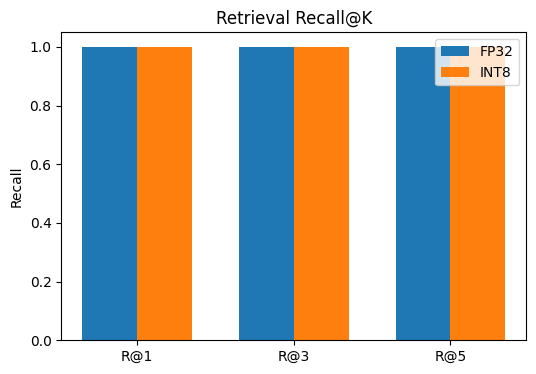

In [89]:
ks = ["R@1","R@3","R@5"]
x = np.arange(len(ks))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x-w/2, rec_fp32, w, label="FP32")
plt.bar(x+w/2, rec_onnx, w, label="INT8")
plt.xticks(x, ks)
plt.ylabel("Recall")
plt.title("Retrieval Recall@K")
plt.legend()
plt.show()


In [90]:
dims = [384, 256, 128]
rec_dim, lat_dim = [], []

for d in dims:
    fn = (lambda t, dd=d: embed_onnx(t, dd))
    rec_dim.append(recall_at_k(fn, 3))
    lat_dim.append(latency(fn, ["test sentence"]))


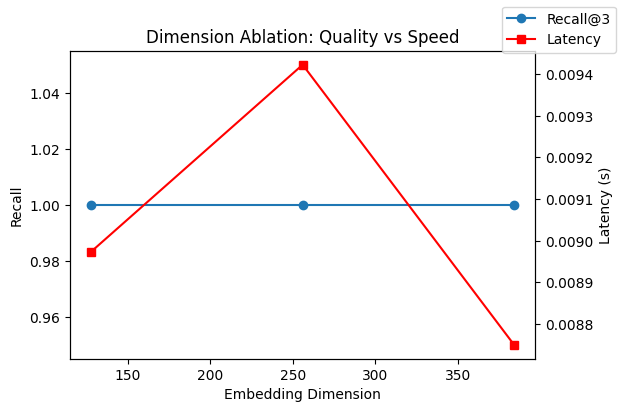

In [91]:
fig, ax1 = plt.subplots(figsize=(6,4))

ax1.plot(dims, rec_dim, marker="o", label="Recall@3")
ax1.set_xlabel("Embedding Dimension")
ax1.set_ylabel("Recall")

ax2 = ax1.twinx()
ax2.plot(dims, lat_dim, marker="s", color="red", label="Latency")
ax2.set_ylabel("Latency (s)")

plt.title("Dimension Ablation: Quality vs Speed")
fig.legend(loc="upper right")
plt.show()


In [93]:
pd.DataFrame({
    "Metric": [
        "Disk Size (MB)",
        "Latency (1 query)",
        "Recall@3",
        "Embedding Dim"
    ],
    "BGE FP32": [
        disk_fp32,
        lat_fp32[0],
        rec_fp32[1],
        384
    ],
    "BGE ONNX INT8": [
        disk_onnx,
        lat_onnx[0],
        rec_onnx[1],
        128
    ]
})


,Metric,BGE FP32,BGE ONNX INT8
0,Disk Size (MB),382.527681,33.328070
1,Latency (1 query),0.476697,0.021438
2,Recall@3,1.000000,1.000000
3,Embedding Dim,384.000000,128.000000
